In [1]:
import os
import re
import numpy as np
import pandas as pd
import shutil
import string
import tensorflow as tf
import tensorflow_datasets as tfds
import tqdm

from tensorflow.keras import Model, preprocessing
from tensorflow.keras.layers import Dot, Embedding , Flatten
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

In [2]:
import matplotlib.pyplot as plt  #plotting graphs for visualization 


def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('yelp_polarity_reviews', with_info=True,as_supervised=True) #download the dataset

train_dataset, test_dataset = dataset['train'], dataset['test'] #segregate the train and test datasets

train_dataset.element_spec

Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteYB8RNM/yelp_polarity_reviews-train.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0.incompleteYB8RNM/yelp_polarity_reviews-test.tfrecord


Dataset yelp_polarity_reviews downloaded and prepared to /root/tensorflow_datasets/yelp_polarity_reviews/plain_text/0.1.0. Subsequent calls will reuse this data.


(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
BUFFER_SIZE = 10000
BATCH_SIZE = 256

In [5]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #preparing train_dataset
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE) #preparing test_dataset

In [6]:
for example, label in train_dataset.take(1):
  print('texts: ', example.numpy()[:3])
  print()
  print('labels: ', label.numpy()[:3])

texts:  [b"If Fleur de Lys were a woman, she would be a triple threat.  \\n\\nYeah you know, one of those.  Looks, personality and brains.\\n\\nConsider me impressed.  Truly beautiful dining experience.  As soon as you walk in, you're greeted with high ceilings and a beautiful decor.\\n\\nRegardless of the fact that I came during restaurant week and ordered off the prix fixe menu, that did not take away from the whole dining experience or the quality of the food. The menu consisted of the following:\\n\\nTruffled Onion Soup or Braised Veal and Yukon Gold Ravioli\\n\\nSeared Skirtsteak or Citrus Glazed Monkfish\\n\\nMolten Chocolate Cake\\n\\nIt was kinda like going on a first date.  You get a little bit of everything, but not enough to scare you away.  Before you had to ask too many questions, the servers came and told you exactly what you were having, leaving some things to the imagination.  \\n\\nThe menu I had left me intrigued and wanting more.\\n\\nUnlike finding that triple threa

In [7]:
VOCAB_SIZE = 1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(max_tokens=VOCAB_SIZE)  #preprocessing and vectorization of data
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
vocab = np.array(encoder.get_vocabulary()) 
vocab[:20]
encoded_example = encoder(example)[:3].numpy() #modified data after text vectorization
encoded_example

array([[ 38,   1, 649, ...,   0,   0,   0],
       [ 35,  30,   3, ...,   0,   0,   0],
       [ 35,   1,  53, ...,   0,   0,   0]])

In [9]:
for n in range(3): #reviewing data after text vectorization
  print("Original: ", example[n].numpy())
  print("Round-trip: ", " ".join(vocab[encoded_example[n]]))
  print()

Original:  b"If Fleur de Lys were a woman, she would be a triple threat.  \\n\\nYeah you know, one of those.  Looks, personality and brains.\\n\\nConsider me impressed.  Truly beautiful dining experience.  As soon as you walk in, you're greeted with high ceilings and a beautiful decor.\\n\\nRegardless of the fact that I came during restaurant week and ordered off the prix fixe menu, that did not take away from the whole dining experience or the quality of the food. The menu consisted of the following:\\n\\nTruffled Onion Soup or Braised Veal and Yukon Gold Ravioli\\n\\nSeared Skirtsteak or Citrus Glazed Monkfish\\n\\nMolten Chocolate Cake\\n\\nIt was kinda like going on a first date.  You get a little bit of everything, but not enough to scare you away.  Before you had to ask too many questions, the servers came and told you exactly what you were having, leaving some things to the imagination.  \\n\\nThe menu I had left me intrigued and wanting more.\\n\\nUnlike finding that triple thr

In [10]:
from tensorflow.keras import layers, callbacks

early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=5, # how many epochs to wait before stopping
    restore_best_weights=True,
)

model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.GRU(1, activation = 'relu')
])

In [11]:
from keras import backend as K  #defining parameters for model evaluation

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [12]:
#Compiling the model
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),# using the BinaryCrossentropy as loss function for a binary classifier
              optimizer=tf.keras.optimizers.Adam(1e-4),#adam as optimizer
              metrics=['accuracy', f1_m,precision_m, recall_m])

In [13]:
#Training the model
history = model.fit(train_dataset, epochs=10, validation_data=test_dataset,validation_steps=30)

Epoch 1/10
2188/2188 [==============================] - 1242s 566ms/step - loss: 0.6437 - accuracy: 0.6338 - f1_m: 0.4205 - precision_m: 0.6322 - recall_m: 0.3531 - val_loss: 0.5853 - val_accuracy: 0.7611 - val_f1_m: 0.7491 - val_precision_m: 0.8037 - val_recall_m: 0.7028
Epoch 2/10
2188/2188 [==============================] - 1253s 573ms/step - loss: 0.5638 - accuracy: 0.7938 - f1_m: 0.7820 - precision_m: 0.8270 - recall_m: 0.7430 - val_loss: 0.5468 - val_accuracy: 0.8116 - val_f1_m: 0.8087 - val_precision_m: 0.8360 - val_recall_m: 0.7843
Epoch 3/10
2188/2188 [==============================] - 1261s 576ms/step - loss: 0.5389 - accuracy: 0.8203 - f1_m: 0.8133 - precision_m: 0.8433 - recall_m: 0.7865 - val_loss: 0.5353 - val_accuracy: 0.8240 - val_f1_m: 0.8220 - val_precision_m: 0.8455 - val_recall_m: 0.8012
Epoch 4/10
2188/2188 [==============================] - 1271s 581ms/step - loss: 0.5302 - accuracy: 0.8305 - f1_m: 0.8249 - precision_m: 0.8504 - recall_m: 0.8021 - val_loss: 0.5307

In [14]:
test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_dataset)

#Evaluating the model

print('Test Loss:', test_loss)
print('Test Accuracy:', test_acc)
print('Test Precision:', precision)
print('Test Recall:', recall)
print('Test F1 Score:', f1_score)

149/149 [==============================] - 21s 139ms/step - loss: 0.5184 - accuracy: 0.8425 - f1_m: 0.8372 - precision_m: 0.8636 - recall_m: 0.8135
Test Loss: 0.5183902382850647
Test Accuracy: 0.8424736857414246
Test Precision: 0.8635911345481873
Test Recall: 0.8135268688201904
Test F1 Score: 0.8371979594230652


(0.0, 0.6500204712152481)

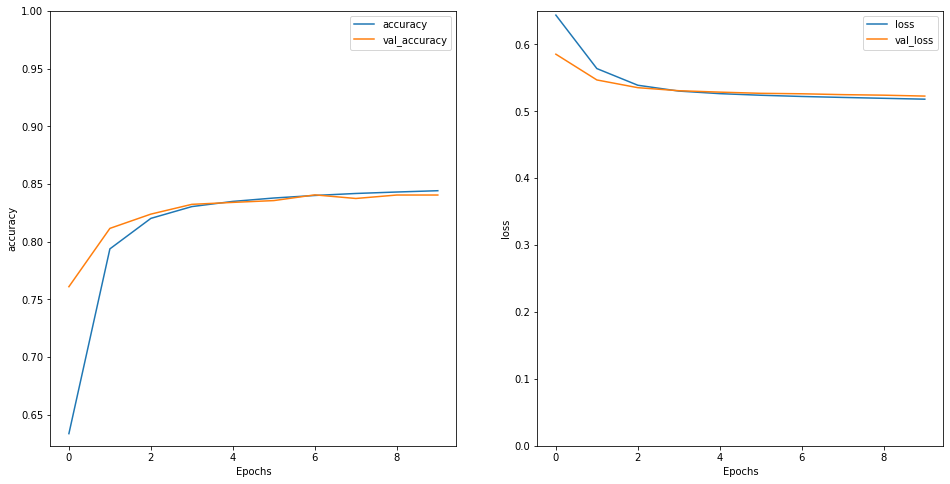

In [15]:
plt.figure(figsize=(16, 8)) #Visualizing the model
plt.subplot(1, 2, 1)
plot_graphs(history, 'accuracy')
plt.ylim(None, 1)
plt.subplot(1, 2, 2)
plot_graphs(history, 'loss')
plt.ylim(0, None)

In [16]:
!mkdir -p ML_models
model.save('ML_models/GRU_model')

INFO:tensorflow:Assets written to: ML_models/GRU_model/assets


INFO:tensorflow:Assets written to: ML_models/GRU_model/assets
